# 라이브러리

In [21]:
# !pip install nibabel
# !pip install scikit-learn

In [114]:
# 경로 처리
import os
from pathlib import Path
import glob

# 일반
import pandas as pd
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'
import numpy as np
import random
import tqdm as tqdm
from sklearn.model_selection import train_test_split

# 이미지 처리
import cv2

# 데이터 경로

In [23]:
# !unzip 'MRI Hippocampus.zip'

In [24]:
# # root directory
# root_dir = Path('Train/Dataset')

# # main path
# non_demented = Path(f'{root_dir}/Non_Demented')
# very_mild_demented = Path(f'{root_dir}/Very_Mild_Demented')
# mild_demented = Path(f'{root_dir}/Mild_Demented')
# moderate_demented = Path(f'{root_dir}/Moderate_Demented')

# # images
# non_demented_img = list(non_demented.glob(r'**/*.jpg'))
# very_mild_demented_img = list(very_mild_demented.glob(r'**/*.jpg'))
# mild_demented_img = list(mild_demented.glob(r'**/*.jpg'))
# moderate_demented_img = list(moderate_demented.glob(r'**/*.jpg'))

In [25]:
# # series 형태로
# non_demented_series = pd.Series(non_demented_img, name='Non_demented').astype(str)
# very_mild_demented_series = pd.Series(very_mild_demented_img, name='Very_mild_demented').astype(str)
# mild_demented_series = pd.Series(mild_demented_img, name='Mild_demented').astype(str)
# moderate_demented_series = pd.Series(moderate_demented_img, name='Moderate_demented').astype(str)

# # 정렬
# non_demented_series = non_demented_series.sort_values().reset_index(drop=True)
# very_mild_demented_series = very_mild_demented_series.sort_values().reset_index(drop=True)
# mild_demented_series = mild_demented_series.sort_values().reset_index(drop=True)
# moderate_demented_series = moderate_demented_series.sort_values().reset_index(drop=True)

# # 확인
# len(non_demented_series), len(very_mild_demented_series), len(mild_demented_series), len(moderate_demented_series)

(3200, 2240, 896, 64)

# 이미지 처리

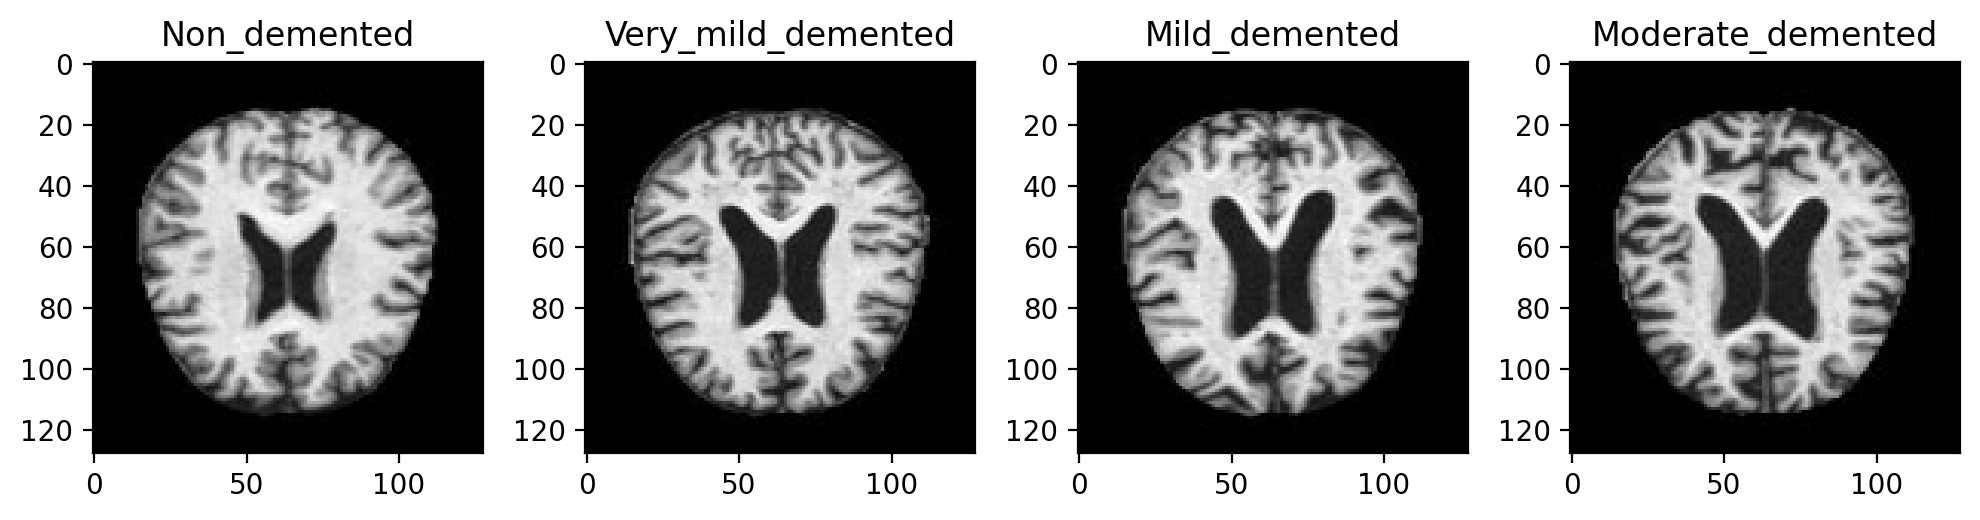

In [82]:
# # 이미지 불러오기
# fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(10, 10))

# example_non = cv2.cvtColor(cv2.imread(non_demented_series[0]), cv2.COLOR_BGR2RGB)
# example_very_mild = cv2.cvtColor(cv2.imread(very_mild_demented_series[0]), cv2.COLOR_BGR2RGB)
# example_mild = cv2.cvtColor(cv2.imread(mild_demented_series[0]), cv2.COLOR_BGR2RGB)
# example_moderate = cv2.cvtColor(cv2.imread(moderate_demented_series[0]), cv2.COLOR_BGR2RGB)

# ax[0].set_title("Non_demented")
# ax[0].imshow(example_non)

# ax[1].set_title("Very_mild_demented")
# ax[1].imshow(example_very_mild)

# ax[2].set_title("Mild_demented")
# ax[2].imshow(example_mild)

# ax[3].set_title("Moderate_demented")
# ax[3].imshow(example_moderate)

# plt.tight_layout()

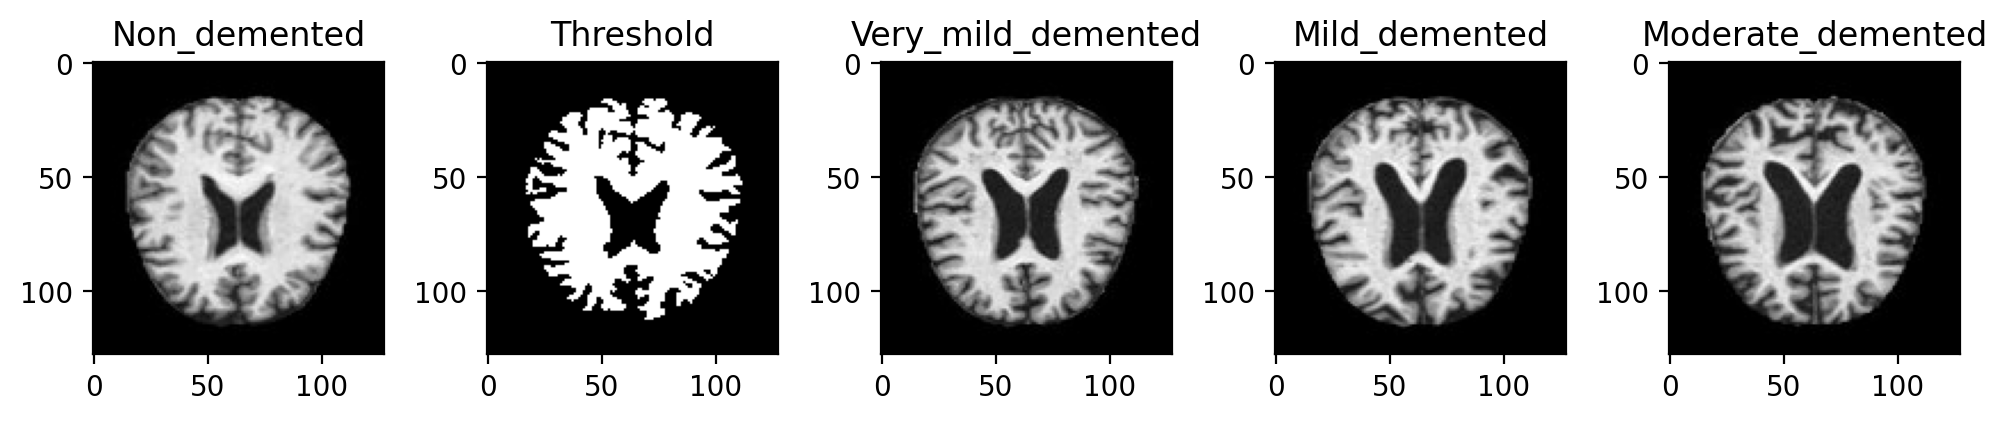

In [83]:
# # threshold 조정
# fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(10, 10))

# example_non = cv2.cvtColor(cv2.imread(non_demented_series[0]), cv2.COLOR_BGR2RGB)
# example_very_mild = cv2.cvtColor(cv2.imread(very_mild_demented_series[0]), cv2.COLOR_BGR2RGB)
# example_mild = cv2.cvtColor(cv2.imread(mild_demented_series[0]), cv2.COLOR_BGR2RGB)
# example_moderate = cv2.cvtColor(cv2.imread(moderate_demented_series[0]), cv2.COLOR_BGR2RGB)

# _, threshold_img = cv2.threshold(example_non, 135, 255, cv2.THRESH_BINARY)

# ax[0].set_title("Non_demented")
# ax[0].imshow(example_non)

# ax[1].set_title("Threshold")
# ax[1].imshow(threshold_img)

# ax[2].set_title("Very_mild_demented")
# ax[2].imshow(example_very_mild)

# ax[3].set_title("Mild_demented")
# ax[3].imshow(example_mild)

# ax[4].set_title("Moderate_demented")
# ax[4].imshow(example_moderate)

# plt.tight_layout()

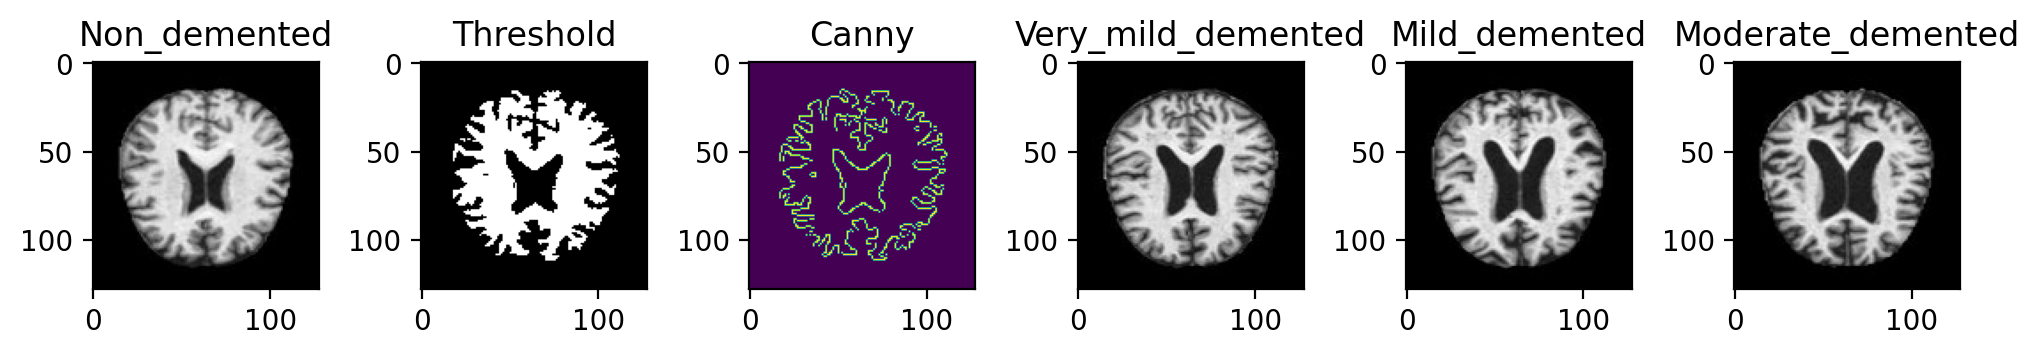

In [112]:
# # canny 로 경계선 따기
# fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(10, 10))

# example_non = cv2.cvtColor(cv2.imread(non_demented_series[0]), cv2.COLOR_BGR2RGB)
# example_very_mild = cv2.cvtColor(cv2.imread(very_mild_demented_series[0]), cv2.COLOR_BGR2RGB)
# example_mild = cv2.cvtColor(cv2.imread(mild_demented_series[0]), cv2.COLOR_BGR2RGB)
# example_moderate = cv2.cvtColor(cv2.imread(moderate_demented_series[0]), cv2.COLOR_BGR2RGB)

# _, threshold_img = cv2.threshold(example_non, 145, 255, cv2.THRESH_BINARY)
# canny_IMG = cv2.Canny(threshold_img, 10, 135, cmap='binary_r')

# ax[0].set_title("Non_demented")
# ax[0].imshow(example_non)

# ax[1].set_title("Threshold")
# ax[1].imshow(threshold_img)

# ax[2].set_title("Canny")
# ax[2].imshow(canny_IMG, cmap='binary_r')

# ax[3].set_title("Very_mild_demented")
# ax[3].imshow(example_very_mild)

# ax[4].set_title("Mild_demented")
# ax[4].imshow(example_mild)

# ax[5].set_title("Moderate_demented")
# ax[5].imshow(example_moderate)

# plt.tight_layout()

In [94]:
# # 3 개의 class 별로 threshold -> canny 과정을 거쳐서 저장
# # non_demented
# non = []
# non_label = []

# for _ in non_demented_series:
#     img = cv2.cvtColor(cv2.imread(_),cv2.COLOR_BGR2RGB)
#     _, threshold_img = cv2.threshold(img,145,255,cv2.THRESH_BINARY)
#     canny_img = cv2.Canny(threshold_img,10,135)
    
#     canny_img = canny_img / 255.
    
#     non_label.append('non')
#     non.append(canny_img)    

In [95]:
# # mild_demented
# mild = []
# mild_label = []

# for _ in very_mild_demented_series:
#     img = cv2.cvtColor(cv2.imread(_),cv2.COLOR_BGR2RGB)
#     _, threshold_img = cv2.threshold(img,145,255,cv2.THRESH_BINARY)
#     canny_img = cv2.Canny(threshold_img,10,135)
    
#     canny_img = canny_img / 255.
    
#     mild_label.append('mild')
#     mild.append(canny_img)

In [96]:
# # moderate_demented
# moderate = []
# moderate_label = []

# for _ in pd.concat([mild_demented_series, moderate_demented_series], axis=0):
#     img = cv2.cvtColor(cv2.imread(_),cv2.COLOR_BGR2RGB)
#     _, threshold_img = cv2.threshold(img,145,255,cv2.THRESH_BINARY)
#     canny_img = cv2.Canny(threshold_img,10,135)
    
#     canny_img = canny_img / 255.
    
#     moderate_label.append('moderate')
#     moderate.append(canny_img)

In [97]:
# # 확인
# len(non), len(non_label), non[0].shape, non_label[0]

(3200, 3200, (128, 128), 'non')

In [121]:
# # np.array 형식으로 만들기
# non_array = np.array(non)
# mild_array = np.array(mild)
# moderate_array = np.array(moderate)

(3200, 128, 128)
[2250 1315 1931 3040 2204]


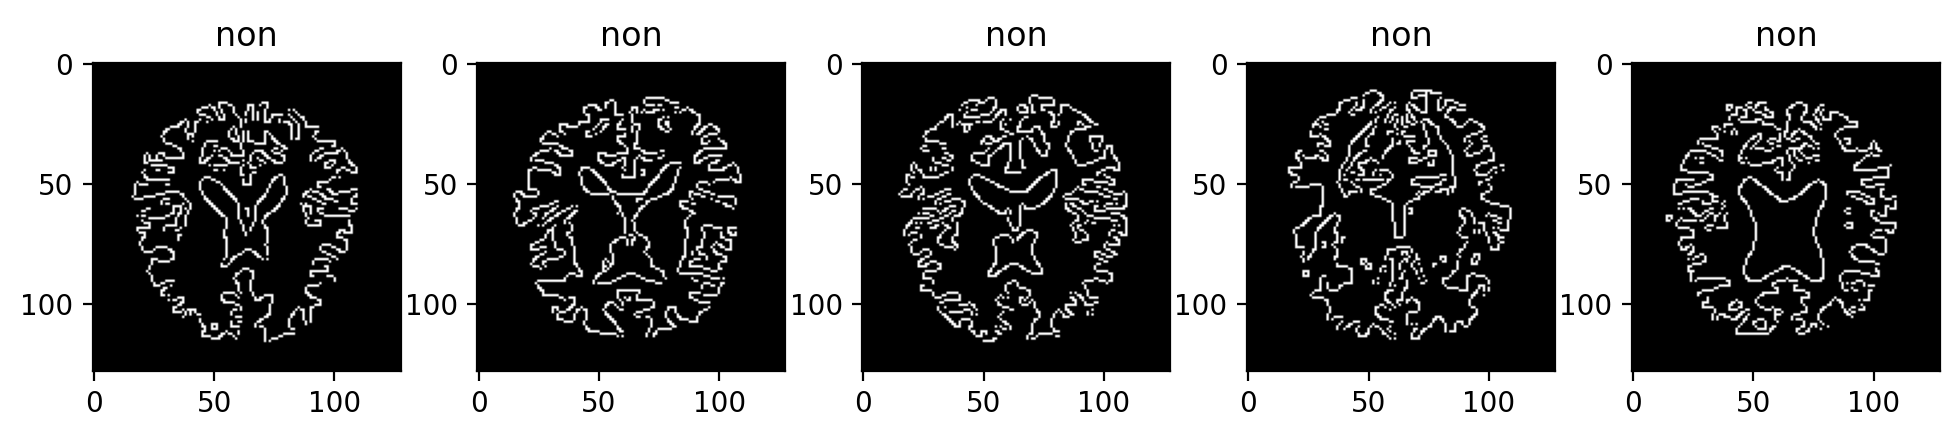

In [123]:
# # 확인
# print(non_array.shape)

# rand_no = np.random.choice(range(non_array.shape[0]), 5)
# print(rand_no)

# fig, axes = plt.subplots(1, 5, figsize=(12, 2))
# for i, r_no in enumerate(rand_no):
#     axes[i].imshow(non_array[r_no], cmap='binary_r')
#     axes[i].set_title(non_label[r_no])

# 모델링